This notebook is part of the ``deepcell-tf`` documentation: https://deepcell.readthedocs.io/.

# Mesmer segmentation

In [1]:
# Download multiplex data
from deepcell.datasets import multiplex_tissue
((X_train, y_train),(X_test, y_test)) = multiplex_tissue.load_data()

51912704/51905517 [==============================] - 3s 0us/step


In [2]:
from deepcell.utils.plot_utils import create_rgb_image

# create rgb overlay of image data for visualization
rgb_images = create_rgb_image(X_train, channel_colors=['green', 'blue'])

# select index for displaying
idx = 3

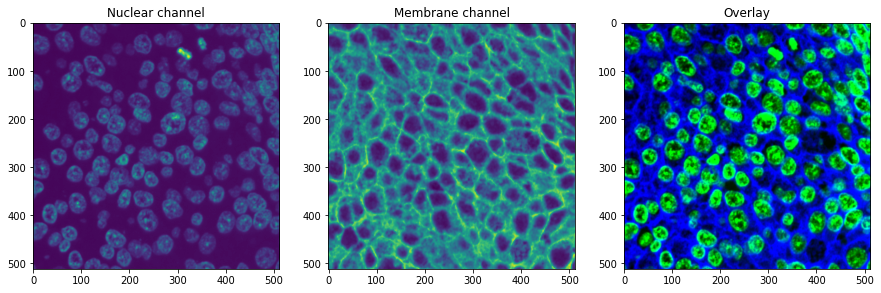

In [3]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X_train[idx, ..., 0])
ax[1].imshow(X_train[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()

## Whole Cell Segmentation

### Initialize Mesmer model

The application will download pretrained weights for tissue segmentation. For more information about application objects, please see our [documentation](https://deepcell.readthedocs.io/en/master/API/deepcell.applications.html).

In [4]:
from deepcell.applications import Mesmer
app = Mesmer()

286965760/286958061 [==============================] - 13s 0us/step


## Use the application to generate labeled images

Typically, neural networks perform best on test data that is similar to the training data. In the realm of biological imaging, the most common difference between datasets is the resolution of the data measured in microns per pixel. The training resolution of the model can be identified using `app.model_mpp`.

In [5]:
print('Training Resolution:', app.model_mpp, 'microns per pixel')

Training Resolution: 0.5 microns per pixel


The resolution of the input data can be specified in `app.predict` using the `image_mpp` option. The `Application` will rescale the input data to match the training resolution and then rescale to the original size before returning the labeled image.

In [6]:
segmentation_predictions = app.predict(X_train, image_mpp=0.5)

In [7]:
# create overlay of predictions
from deepcell.utils.plot_utils import make_outline_overlay
overlay_data = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions)

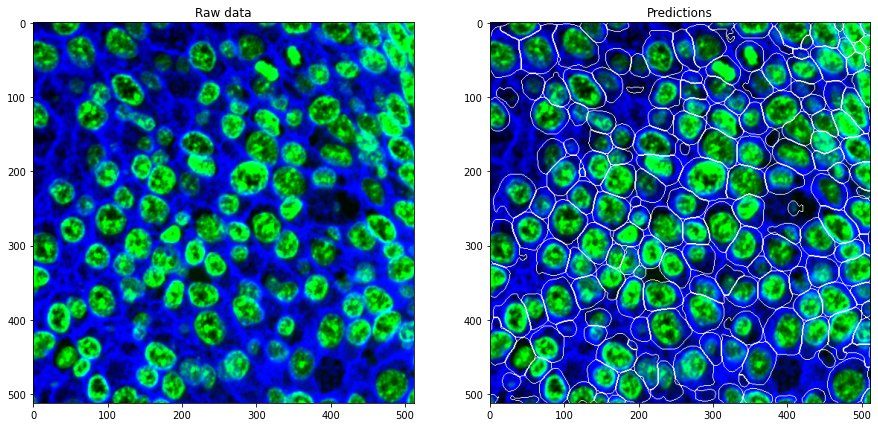

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Predictions')
plt.show()

## Nuclear Cell Segmentation

In addition to predicting whole-cell segmentation, Mesmer can also be used for nuclear predictions

In [9]:
segmentation_predictions_nuc = app.predict(X_train, image_mpp=0.5, compartment='nuclear')

In [10]:
overlay_data_nuc = make_outline_overlay(rgb_data=rgb_images, predictions=segmentation_predictions_nuc)

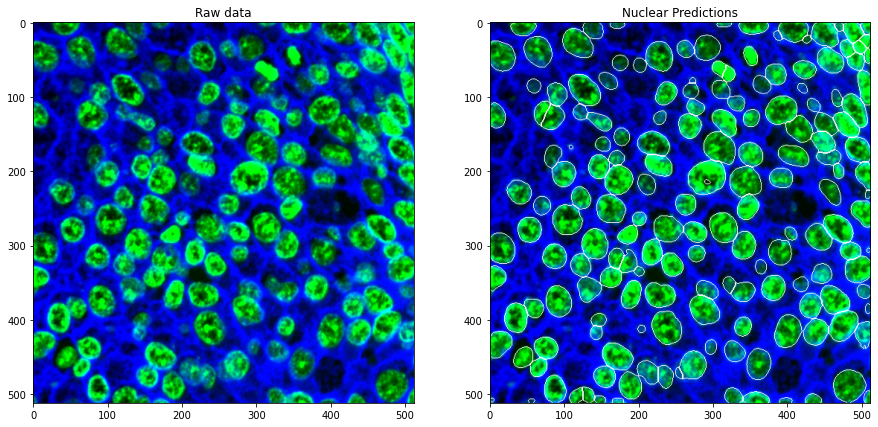

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(rgb_images[idx, ...])
ax[1].imshow(overlay_data_nuc[idx, ...])
ax[0].set_title('Raw data')
ax[1].set_title('Nuclear Predictions')
plt.show()